In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Supplementary_exports'
data_folder = '../all_data/Supplementary_data'

In [3]:
raw = pd.read_pickle(data_folder+'/expanded_search_data_raw.pkl').reset_index()
raw

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,Chol_conc,Spermidine,PE_conc,pmol,rxn_id
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,0.000,4.000,0.000,4.918,0.000
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,0.000,4.000,0.000,4.311,0.000
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,0.000,4.000,0.000,2.644,0.000
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,0.000,4.000,0.000,7.546,0.000
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,0.000,4.000,0.000,7.527,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33546,eCM313,2.000,4.000,G6,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,0.000,4.000,0.000,2.024,3966.000
33547,eCM329,1.000,3.000,L19,S26,Vol,5.000,no_lipo,0,20.000,1.250,135,BL65,0.000,0.000,0.000,0.000,2.069,3967.000
33548,eCM329,1.000,3.000,I11,S26,Vol,5.000,no_lipo,0,20.000,1.250,135,BL65,0.000,0.000,0.000,0.000,2.290,3967.000
33549,eCM329,1.000,3.000,E20,S26,Vol,5.000,no_lipo,0,20.000,1.250,135,BL65,0.000,0.000,0.000,0.000,2.120,3967.000


### Limit the reactions to only include the larger parameter space

In [4]:
exp_sub = raw.copy()
exp_sub = exp_sub[~exp_sub.experiment_id.isin(['eCM305','eCM308','eCM309','eCM310','eCM311'])]
exp_sub = exp_sub[~exp_sub.DNA_name.isin(['Blank','Phos'])]


### Assign the reactions as either screening or active-learning selected reactions

In [5]:
screen_ids = ['eCM324','eCM328']
active_ids = ['eCM325','eCM329','eCM330']

labelled = exp_sub.copy()

def assign_label(exp_id):
    if exp_id in screen_ids:
        return 'screen'
    elif exp_id in active_ids:
        return 'active'
    else:
        return 'other'

exp_sub['label'] = exp_sub['experiment_id'].apply(assign_label)
exp_sub[['label']].value_counts()

label 
other     17897
screen     6921
active     5121
Name: count, dtype: int64

In [6]:
exp_sub[exp_sub['label'] == 'active'].value_counts('experiment_id')

experiment_id
eCM330    1811
eCM329    1753
eCM325    1557
Name: count, dtype: int64

### Calculate the change in signal between the reaction and the corresponding no liposome control

In [7]:
sub_df = []

for rxn_id,rxn_df in exp_sub.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

375.0
380.0
389.0
390.0
433.0
838.0
884.0
2032.0
2051.0
2056.0
2057.0
2186.0
2187.0
2230.0
2231.0
2692.0
2699.0
2705.0
2708.0
3872.0
3897.0


,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,...,K,WCE,PEG,Chol_conc,Spermidine,PE_conc,pmol,rxn_id,label,pmol_sub
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,...,85,BL62,2.000,0.000,4.000,0.000,4.918,0.000,other,2.688
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,...,85,BL62,2.000,0.000,4.000,0.000,4.311,0.000,other,2.081
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,...,85,BL62,2.000,0.000,4.000,0.000,2.644,0.000,other,0.414
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,...,85,BL62,2.000,0.000,4.000,0.000,7.546,0.000,other,5.316
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,...,85,BL62,2.000,0.000,4.000,0.000,7.527,0.000,other,5.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15754,eCM329,1.000,3.000,C18,S26,Vol,5.000,DOPC,3,20.000,...,135,BL65,0.000,0.000,0.000,0.000,1.831,3967.000,active,-0.224
33547,eCM329,1.000,3.000,L19,S26,Vol,5.000,no_lipo,0,20.000,...,135,BL65,0.000,0.000,0.000,0.000,2.069,3967.000,active,0.013
33548,eCM329,1.000,3.000,I11,S26,Vol,5.000,no_lipo,0,20.000,...,135,BL65,0.000,0.000,0.000,0.000,2.290,3967.000,active,0.235
33549,eCM329,1.000,3.000,E20,S26,Vol,5.000,no_lipo,0,20.000,...,135,BL65,0.000,0.000,0.000,0.000,2.120,3967.000,active,0.065


In [9]:
exp_variables = ['DNA_name','Mg','K','SecYE','Liposome_name','DNA_conc','PE_conc','Spermidine','Chol_conc']
print(len(sub_df['DNA_name'].unique()))
print(len(exp_variables)-2)
t = sub_df[sub_df['label'] == 'active']
stacked = t[exp_variables].stack().reset_index()
for g,g_df in stacked.groupby('level_1'):
    num_unique = len(g_df[0].unique())
    print(f'{g}: {num_unique}, {g_df[0].unique()}')


28
7
Chol_conc: 2, [0.0 8.0]
DNA_conc: 2, [2.5 5.0]
DNA_name: 24, ['Aux' 'B2AR' 'B3AR' 'Beta' 'CD47' 'CD63' 'CD81' 'CD9' 'CML1' 'CRCM' 'CaM'
 'Cx43' 'Dia' 'FFAR4' 'Glut' 'InP' 'Mito' 'Mol' 'Neu' 'OR1A1' 'OR1D2'
 'OR1E1' 'OR2AG1' 'Vol']
K: 4, [235 185 85 135]
Liposome_name: 3, ['DMPC' 'no_lipo' 'DOPC']
Mg: 5, [8.0 11.0 14.0 17.0 20.0]
PE_conc: 2, [15.0 0.0]
SecYE: 3, [0.625 0.0 1.25]
Spermidine: 5, [8.0 4.0 0.0 0.1 1.0]


### Calculate the difference and significance of the difference between the negative control and experimental conditions

In [10]:
used = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
used = used[used['label'] != 'other']
means = used.groupby('rxn_id')[['pmol','pmol_sub']].agg("mean")
used = means.join(used[['label','rxn_id','pmol','pmol_sub'] + exp_variables].set_index('rxn_id'),lsuffix='_mean').drop_duplicates()

p_vals = []
for dna,dna_df in used.groupby('DNA_name'):
    a = dna_df[dna_df['label'] == 'active']
    s = dna_df[dna_df['label'] == 'screen']
    
    pval = -np.log(ttest_ind(a['pmol_sub'],s['pmol_sub'])[1])
    a_mean = a['pmol_sub'].mean()
    s_mean = s['pmol_sub'].mean()
    
    diff = a_mean - s_mean
    print(dna,round(a_mean,2),round(s_mean,2),round(diff,2),round(pval,2))
    p_vals.append([dna,diff,pval])
    
p_vals = pd.DataFrame(p_vals,columns=['DNA_name','diff','pval'])
p_vals['pval'] = p_vals['pval'].clip(0,50)

Aux 0.31 0.1 0.21 10.32
B2AR 0.06 0.15 -0.09 2.96
B3AR -0.0 0.02 -0.03 0.5
Beta 1.13 0.14 0.98 42.28
CD47 0.8 1.09 -0.29 4.45
CD63 0.28 0.17 0.11 2.64
CD81 0.09 0.08 0.02 0.23
CD9 0.26 0.2 0.06 1.23
CML1 0.04 0.02 0.02 0.33
CRCM 0.03 -0.01 0.04 0.7
CaM 0.15 -0.1 0.24 18.59
Cx43 0.03 0.04 -0.02 0.26
Dia 1.1 0.69 0.41 8.74
FFAR4 0.15 0.03 0.12 4.0
Glut 0.23 0.07 0.16 8.34
InP 0.36 0.17 0.19 6.36
Mito 1.92 0.72 1.21 31.41
Mol 0.48 0.1 0.38 22.43
Neu 0.26 0.1 0.15 6.96
OR1A1 0.78 0.59 0.19 2.09
OR1D2 0.08 0.04 0.04 1.04
OR1E1 0.06 0.01 0.05 1.49
OR2AG1 0.26 -0.01 0.27 10.37
Vol 0.2 -0.01 0.21 5.93


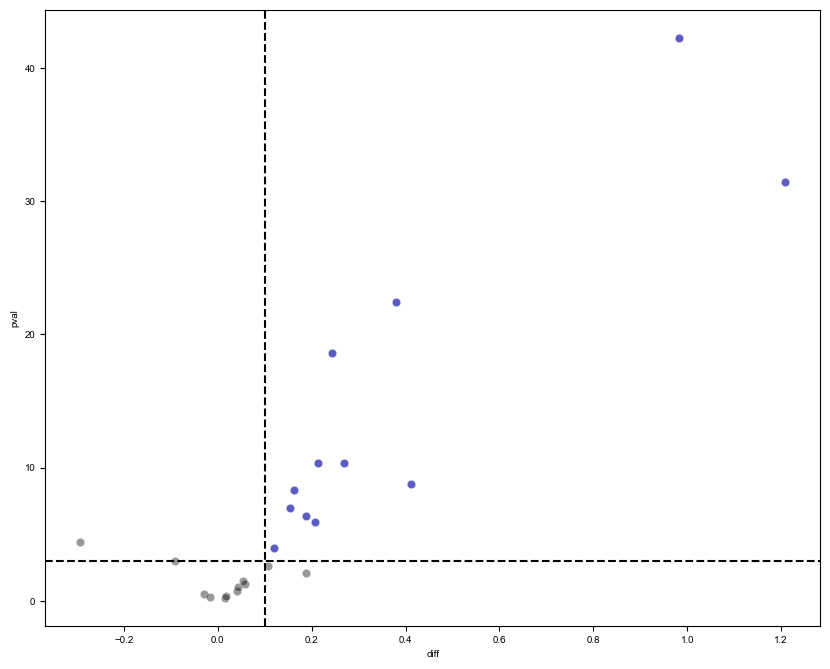

In [11]:
x_thresh = 0.1
y_thresh = -np.log(0.05)

sns.scatterplot(data=p_vals,x='diff',y='pval',alpha=0.4,color='black')
sns.scatterplot(data=p_vals[(p_vals['diff'] > x_thresh) & (p_vals['pval'] > y_thresh)],x='diff',y='pval',alpha=0.4,color='blue')

plt.axvline(x_thresh,color='black',ls='--')
plt.axhline(y_thresh,color='black',ls='--')

plt.show()

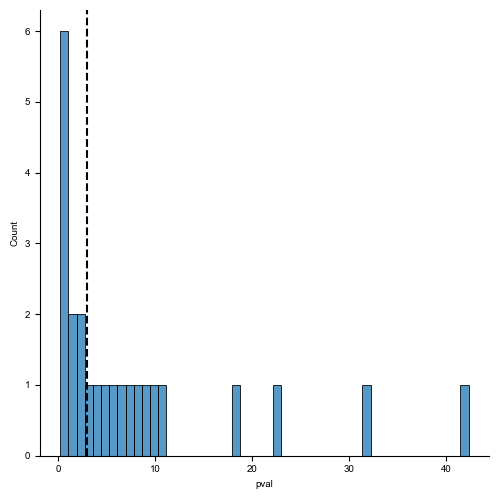

In [12]:
sns.displot(data=p_vals,x='pval',bins=50)
plt.axvline(3,color='k',ls='--')
plt.show()

In [13]:
significant = p_vals[p_vals['pval'] > -np.log(0.05)]['DNA_name'].tolist()
significant = [x for x in significant if x != 'Cx43']
len(significant)

13

### Calculate general statistics for the synthesis of each protein

In [14]:
medians = used.groupby(['label','DNA_name'])[['pmol','pmol_sub']].agg("median")
means = used.groupby(['label','DNA_name'])[['pmol','pmol_sub']].agg("mean")
maxs = used.groupby(['label','DNA_name'])[['pmol','pmol_sub']].agg("max")
calcs = medians.join(means,lsuffix='_median',rsuffix='_mean').join(maxs)
calcs = calcs.rename(columns={'pmol':'pmol_max','pmol_sub':'pmol_sub_max'})
calcs = calcs.reset_index()
gen_calcs = calcs.copy()


In [15]:
used = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
used = used[used['label'] != 'other']

lipo_all = used[used['Liposome_name'] != 'no_lipo'].copy()
means = lipo_all.groupby('rxn_id')[['pmol','pmol_sub']].agg("mean")
lipo_all = means.join(lipo_all[['label','rxn_id','DNA_name','Mg','K','PEG','SecYE','Liposome_name','pmol','pmol_sub']].set_index('rxn_id'),lsuffix='_mean').drop_duplicates()


In [16]:
lipo_means = lipo_all.reset_index().drop_duplicates(subset='rxn_id').drop(columns=['pmol','pmol_sub']).rename(columns={'pmol_mean':'pmol','pmol_sub_mean':'pmol_sub'})
lipo_means.value_counts(['DNA_name'])

DNA_name
Aux         64
CaM         64
Neu         64
Mol         64
Mito        64
            ..
B3AR        48
OR1A1       48
OR1D2       48
OR1E1       48
OR2AG1      48
Name: count, Length: 24, dtype: int64

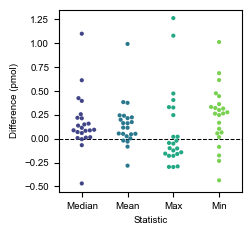

In [17]:
lipo_means = lipo_all.reset_index().drop_duplicates(subset='rxn_id').drop(columns=['pmol','pmol_sub']).rename(columns={'pmol_mean':'pmol','pmol_sub_mean':'pmol_sub'})

medians = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("median")

medians = medians.unstack()
medians.columns = ['active','screen']
medians['diff'] = medians['active'] - medians['screen']
medians['percent'] = (medians['active'] - medians['screen']) / medians['screen']
medians['label'] = 'Median'

means = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("mean")
means = means.unstack()
means.columns = ['active','screen']
means['diff'] = means['active'] - means['screen']
means['percent'] = (means['active'] - means['screen']) / means['screen']
means['label'] = 'Mean'

maxs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("max")
maxs = maxs.unstack()
maxs.columns = ['active','screen']
maxs['diff'] = maxs['active'] - maxs['screen']
maxs['percent'] = (maxs['active'] - maxs['screen']) / maxs['screen']
maxs['label'] = 'Max'

mins = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("min")
mins = mins.unstack()
mins.columns = ['active','screen']
mins['diff'] = mins['active'] - mins['screen']
mins['percent'] = (mins['active'] - mins['screen']) / mins['screen']
mins['label'] = 'Min'

stdevs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("std")
stdevs = stdevs.unstack()
stdevs.columns = ['active','screen']
stdevs['diff'] = stdevs['active'] - stdevs['screen']
stdevs['percent'] = (stdevs['active'] - stdevs['screen']) / stdevs['screen']
stdevs['label'] = 'Stdev'

calcs = pd.concat([medians,means,maxs,mins]).reset_index()
calcs['percent'] = calcs['percent'].clip(-2,2)

meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
calcs = calcs.set_index('DNA_name').join(meta.set_index('DNA_name')).reset_index()

high = ['AqpZ','MscL','Mito']
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

current = calcs[(~calcs['DNA_name'].isin(high))]

sns.swarmplot(data=current,x='label',y='diff',ax=ax,s=3,palette='viridis',hue='label',legend=False)
plt.axhline(0,c='k',ls='--',lw=0.75)
plt.xlabel('Statistic')
plt.ylabel('Difference (pmol)')
# plt.savefig(f'{fig_folder}/all_stats_comparison.svg',format='svg',dpi=300)
plt.show()

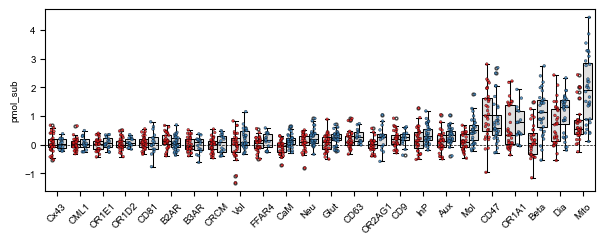

In [18]:
t = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg("median").reset_index()

t = t[t['label'] == 'active'].sort_values('pmol_sub')
sig_dna_order = t['DNA_name'].tolist()

fig,ax = plt.subplots(figsize=[18*cm,6*cm])
PROPS = {
    'boxprops':{'edgecolor':'black','facecolor':'#e0e0e0'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'color':'none'}
}
current = lipo_means

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=sig_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=sig_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')
plt.xlabel('')

plt.savefig(f'{fig_folder}/Supp_Fig_17-exp_active_boxplots_all.svg',format='svg',dpi=300)
plt.show()
current.to_excel(f'{data_folder}/Supp_Fig_17-expanded_averages_boxplot.xlsx')

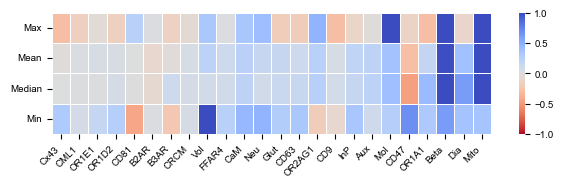

In [19]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T
comps = comps[sig_dna_order]
fig,ax = plt.subplots(figsize=[18*cm,4*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Supp_Fig_17-exp_changes-heatmap_all.svg',format='svg',dpi=300)

plt.show()
comps.to_excel(f'{data_folder}/Supp_Fig_17-expanded_active_heatmap.xlsx')